In [207]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from multiprocessing import Pool
from nltk.corpus import wordnet
import pylab as pl
import seaborn as sns
tqdm.pandas()
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
from plotly.offline import iplot

## Data Pre-processing and Cleaning 

In [208]:
df = pd.read_csv('Kaggle_40.csv')

In [209]:
df.head()

,subreddit,body,controversiality,score
0,gameofthrones,Your submission has been automatically removed...,0,1
1,aww,"Dont squeeze her with you massive hand, you me...",0,19
2,gaming,It's pretty well known and it was a paid produ...,0,3
3,news,You know we have laws against that currently c...,0,10
4,politics,"Yes, there is a difference between gentle supp...",0,1


In [24]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 4.8 MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047105 sha256=e9b29a0e870f2bca2b612f77af27e30ec690a426d35557c2e152d243bdb9147e
  Stored in directory: /private/var/folders/1v/_qmv8ykn1g996_cgt0yq6p8w0000gn/T/pip-ephem-wheel-cache-ime8qs7n/wheels/ee/4d/f7/563214122be1540b5f9197b52cb3ddb9c4a8070808b22d5a84
Successfully built en-core-web-sm
You should consider upgrading via the '/Users/renjun/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/renjun/opt/anaconda3/lib/python3.8/site-packages/en_core_web_sm -->
/Users/renjun/opt/anaconda3/lib/python3.8/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


## EDA

In [210]:
import spacy
nlp = spacy.load('en')
docs = nlp.pipe(df.body, n_process=10)
df['tokens'] = [[i.lemma_ for i in r] for r in tqdm(docs)]

1000000it [15:24, 1081.82it/s]


In [211]:
from collections import Counter, defaultdict
CATEGORY_HEADER = 'subreddit'
tokens_counter = Counter()
category_tokens_counter = defaultdict(Counter)
_ = df.progress_apply(lambda r: (tokens_counter.update(r['tokens']), category_tokens_counter[r[CATEGORY_HEADER]].update(r['tokens'])), axis=1)
nb_tokens = sum(tokens_counter.values())
nb_token_per_category = {category: sum(c.values()) for category, c in category_tokens_counter.items()}

100%|██████████| 1000000/1000000 [00:40<00:00, 24502.83it/s]


In [212]:
TOPN_TOKENS = 3000
print('keeping %s tokens out of %s' % (TOPN_TOKENS, nb_tokens))


def representativeness(token, tokens_counter, category_tokens_counter, nb_tokens, nb_token_per_categ):
    representativeness_scores = {
        categ: category_tokens_counter.get(categ).get(token, 0) / tokens_counter.get(token) * nb_tokens / nb_token_per_categ[categ] for categ in category_tokens_counter.keys()
    
    }
    representativeness_scores['token'] = token
    representativeness_scores['token_count'] = tokens_counter.get(token)
    return representativeness_scores

representativeness_df = pd.DataFrame([representativeness(x[0], tokens_counter, category_tokens_counter, nb_tokens, nb_token_per_category) for x in tokens_counter.most_common(TOPN_TOKENS)])
representativeness_df.sort_values(by='token_count', inplace=True, ascending=False)

keeping 3000 tokens out of 35851373


In [213]:
#token we don't want
BAN_SET = {'/','*','^'}

def ban_token(token, ban_set):
    return bool(set(token).intersection(ban_set))

representativeness_df['ban'] = representativeness_df.token.apply(lambda r: ban_token(r, BAN_SET))
representativeness_df = representativeness_df[representativeness_df.ban == False]
representativeness_df = representativeness_df.set_index('token')

[[None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None,

<AxesSubplot:>

Text(0.5, 1.0, 'gameofthrones')

<AxesSubplot:>

Text(0.5, 1.0, 'aww')

<AxesSubplot:>

Text(0.5, 1.0, 'gaming')

<AxesSubplot:>

Text(0.5, 1.0, 'news')

<AxesSubplot:>

Text(0.5, 1.0, 'politics')

<AxesSubplot:>

Text(0.5, 1.0, 'dankmemes')

<AxesSubplot:>

Text(0.5, 1.0, 'relationship_advice')

<AxesSubplot:>

Text(0.5, 1.0, 'nba')

<AxesSubplot:>

Text(0.5, 1.0, 'worldnews')

<AxesSubplot:>

Text(0.5, 1.0, 'AskReddit')

<AxesSubplot:>

Text(0.5, 1.0, 'AmItheAsshole')

<AxesSubplot:>

Text(0.5, 1.0, 'SquaredCircle')

<AxesSubplot:>

Text(0.5, 1.0, 'The_Donald')

<AxesSubplot:>

Text(0.5, 1.0, 'leagueoflegends')

<AxesSubplot:>

Text(0.5, 1.0, 'hockey')

<AxesSubplot:>

Text(0.5, 1.0, 'videos')

<AxesSubplot:>

Text(0.5, 1.0, 'teenagers')

<AxesSubplot:>

Text(0.5, 1.0, 'gonewild')

<AxesSubplot:>

Text(0.5, 1.0, 'movies')

<AxesSubplot:>

Text(0.5, 1.0, 'funny')

<AxesSubplot:>

Text(0.5, 1.0, 'pics')

<AxesSubplot:>

Text(0.5, 1.0, 'marvelstudios')

<AxesSubplot:>

Text(0.5, 1.0, 'memes')

<AxesSubplot:>

Text(0.5, 1.0, 'soccer')

<AxesSubplot:>

Text(0.5, 1.0, 'freefolk')

<AxesSubplot:>

Text(0.5, 1.0, 'MortalKombat')

<AxesSubplot:>

Text(0.5, 1.0, 'todayilearned')

<AxesSubplot:>

Text(0.5, 1.0, 'apexlegends')

<AxesSubplot:>

Text(0.5, 1.0, 'asoiaf')

<AxesSubplot:>

Text(0.5, 1.0, 'Market76')

<AxesSubplot:>

Text(0.5, 1.0, 'Animemes')

<AxesSubplot:>

Text(0.5, 1.0, 'FortNiteBR')

<AxesSubplot:>

Text(0.5, 1.0, 'nfl')

<AxesSubplot:>

Text(0.5, 1.0, 'trashy')

<AxesSubplot:>

Text(0.5, 1.0, 'unpopularopinion')

<AxesSubplot:>

Text(0.5, 1.0, 'ChapoTrapHouse')

<AxesSubplot:>

Text(0.5, 1.0, 'RoastMe')

<AxesSubplot:>

Text(0.5, 1.0, 'Showerthoughts')

<AxesSubplot:>

Text(0.5, 1.0, 'wallstreetbets')

<AxesSubplot:>

Text(0.5, 1.0, 'Pikabu')

Text(0.5, 1.0, 'Most used words per subreddit (top 3000 words)')

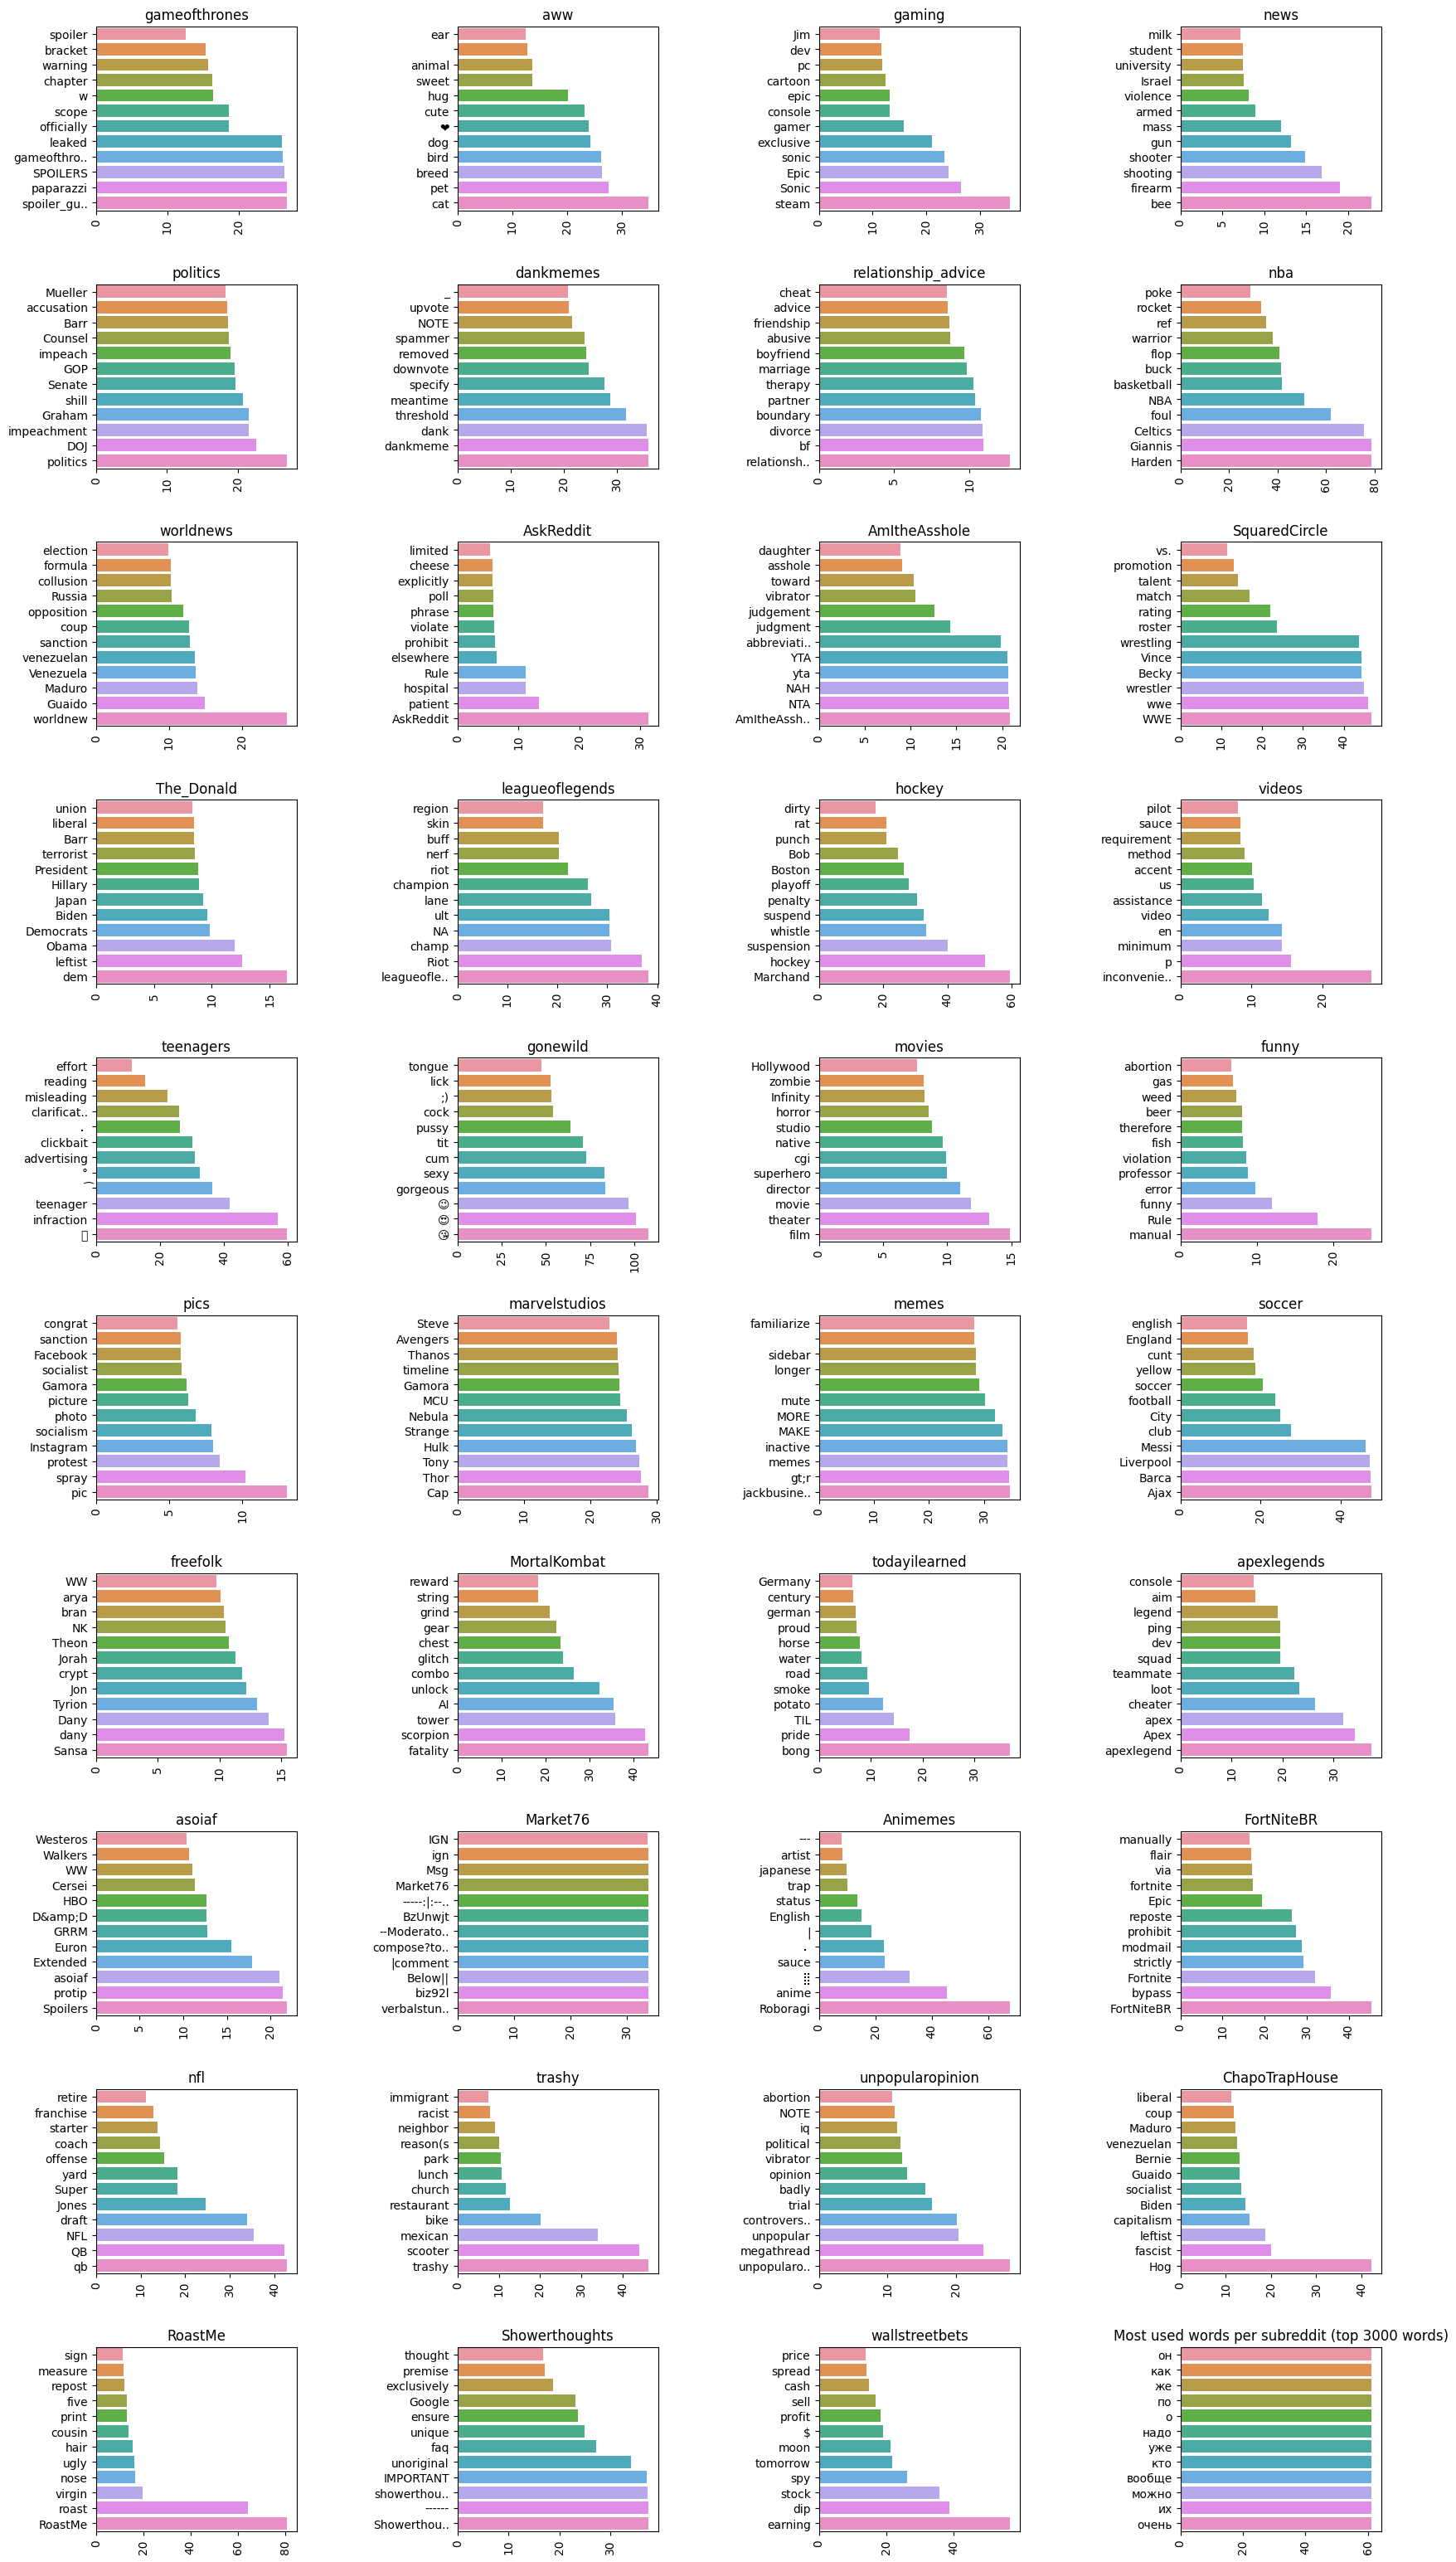

In [214]:
TOPN_PER_SUB = 12
MAX_VISUAL_TOKEN_LEN = 12

fig, axes = pl.subplots(10, 4, figsize=(20, 40), dpi=100, facecolor='w', edgecolor='k')
axes = axes.flatten()

[pl.setp(ax.get_xticklabels(), rotation=90) for ax in axes]

pl.subplots_adjust(wspace=0.8)
pl.subplots_adjust(hspace=0.4)

for i, subreddit in enumerate(category_tokens_counter.keys()):
    sorted_scores = representativeness_df[subreddit].sort_values()
    topn = sorted_scores.tail(TOPN_PER_SUB)
    xlabels = [i if len(i) < MAX_VISUAL_TOKEN_LEN else i[:MAX_VISUAL_TOKEN_LEN-2] + '..' for i in topn.index ]
    sns.barplot(topn.values, xlabels, ax=axes[i])
    axes[i].set_title(subreddit)
    
pl.title("Most used words per subreddit (top %s words)" % TOPN_TOKENS)

[[None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None, None, None, None, None, None, None, None, None],
 [None, None, None, None,

<AxesSubplot:>

Text(0.5, 1.0, 'gameofthrones')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'aww')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'gaming')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'news')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'politics')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'dankmemes')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'relationship_advice')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'nba')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'worldnews')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'AskReddit')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'AmItheAsshole')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'SquaredCircle')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'The_Donald')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'leagueoflegends')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'hockey')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'videos')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'teenagers')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'gonewild')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'movies')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'funny')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'pics')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'marvelstudios')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'memes')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'soccer')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'freefolk')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'MortalKombat')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'todayilearned')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'apexlegends')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'asoiaf')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'Market76')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'Animemes')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'FortNiteBR')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'nfl')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'trashy')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'unpopularopinion')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'ChapoTrapHouse')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'RoastMe')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'Showerthoughts')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'wallstreetbets')

(0.0, 60.0)

<AxesSubplot:>

Text(0.5, 1.0, 'Pikabu')

(0.0, 60.0)

Text(0.5, 1.0, 'Representativeness distribution / subreddit')

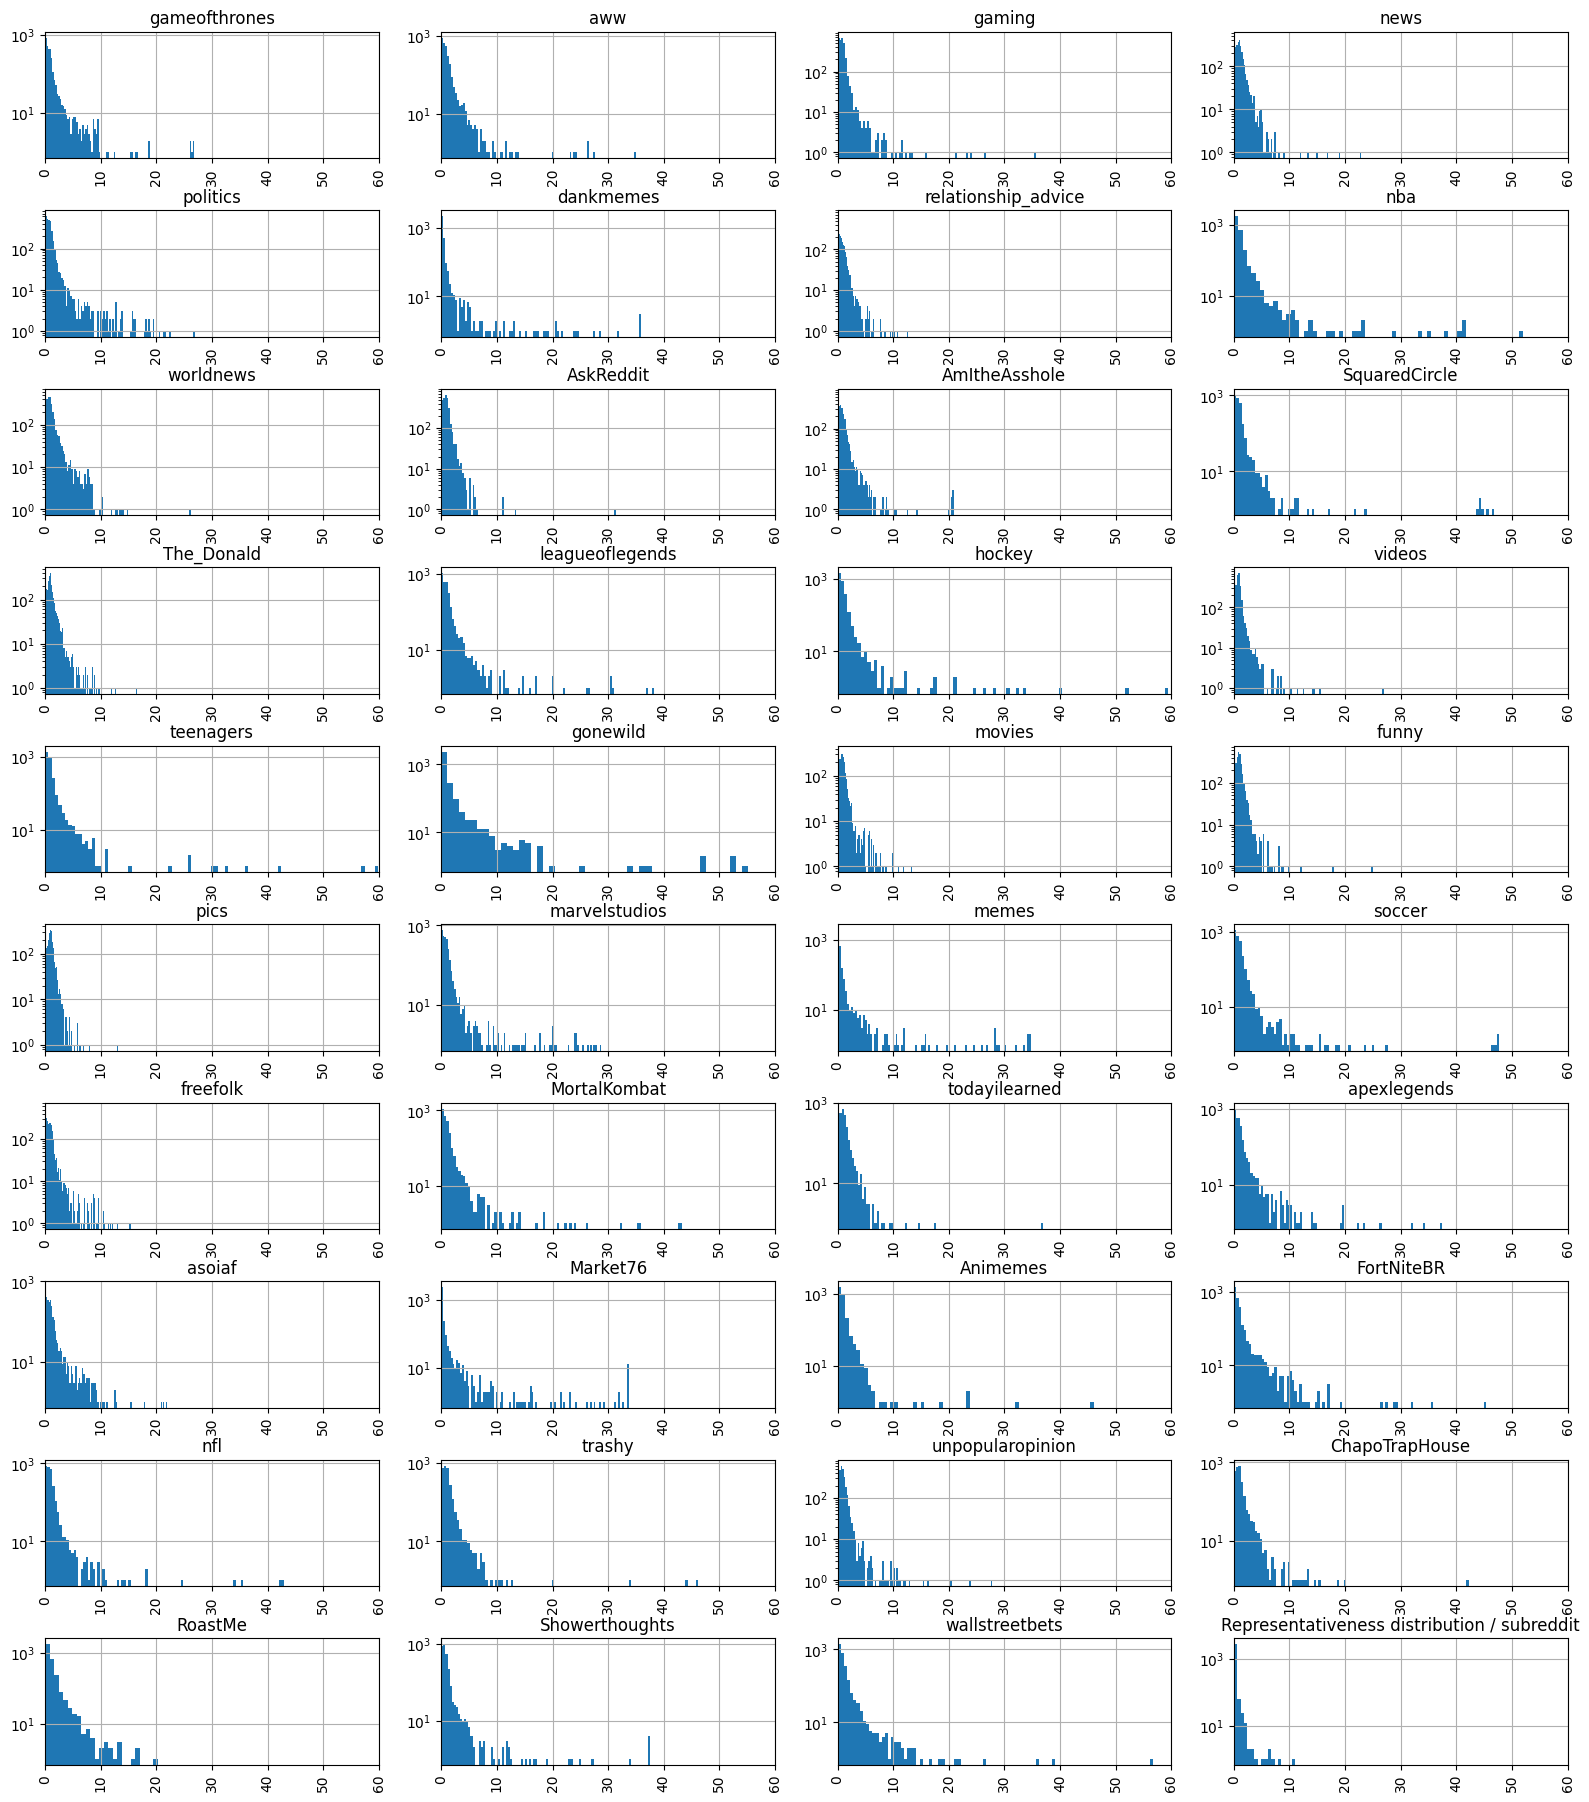

In [215]:
fig, axes = pl.subplots(10, 4, figsize=(16, 18), dpi=100, facecolor='w', edgecolor='k')
axes = axes.flatten()
[pl.setp(ax.get_xticklabels(), rotation=90) for ax in axes]
fig.tight_layout()
for i, subreddit in enumerate(category_tokens_counter.keys()):
    sorted_scores = representativeness_df[subreddit].sort_values()
    representativeness_df[subreddit].hist(ax=axes[i], bins=100)
    axes[i].set_title(subreddit)
    axes[i].set_yscale('log')
    axes[i].set_xlim(0, 60)
pl.title("Representativeness distribution / subreddit")

In [43]:
df.head()

,subreddit,body,controversiality,score,tokens
0,gameofthrones,Your submission has been automatically removed...,0,1,"[-PRON-, submission, have, be, automatically, ..."
1,aww,"Dont squeeze her with you massive hand, you me...",0,19,"[do, not, squeeze, -PRON-, with, -PRON-, massi..."
2,gaming,It's pretty well known and it was a paid produ...,0,3,"[-PRON-, be, pretty, well, known, and, -PRON-,..."
3,news,You know we have laws against that currently c...,0,10,"[-PRON-, know, -PRON-, have, law, against, tha..."
4,politics,"Yes, there is a difference between gentle supp...",0,1,"[yes, ,, there, be, a, difference, between, ge..."


In [52]:
df = df[df['subreddit'] != 'Pikabu']

In [53]:
df

,subreddit,body,controversiality,score,tokens
0,gameofthrones,Your submission has been automatically removed...,0,1,"[-PRON-, submission, have, be, automatically, ..."
1,aww,"Dont squeeze her with you massive hand, you me...",0,19,"[do, not, squeeze, -PRON-, with, -PRON-, massi..."
2,gaming,It's pretty well known and it was a paid produ...,0,3,"[-PRON-, be, pretty, well, known, and, -PRON-,..."
3,news,You know we have laws against that currently c...,0,10,"[-PRON-, know, -PRON-, have, law, against, tha..."
4,politics,"Yes, there is a difference between gentle supp...",0,1,"[yes, ,, there, be, a, difference, between, ge..."
...,...,...,...,...,...
999868,trashy,They are fighting a violent regime,0,-5,"[-PRON-, be, fight, a, violent, regime]"
999870,trashy,LOL. He also said something about turning them...,0,1,"[lol, ., -PRON-, also, say, something, about, ..."
999871,trashy,Yeah I love helping and being close to my fami...,0,1,"[yeah, -PRON-, love, help, and, be, close, to,..."
999876,trashy,As a Canadian lefty I have to say I find Ameri...,0,11,"[as, a, canadian, lefty, -PRON-, have, to, say..."


In [54]:
df = df.sample(frac=1)

In [55]:
df

,subreddit,body,controversiality,score,tokens
460253,freefolk,ffs mate do you really believe they put her on...,0,2,"[ffs, mate, do, -PRON-, really, believe, -PRON..."
388316,todayilearned,Piss prophets: your piss has blood in it - you...,0,5,"[piss, prophet, :, -PRON-, piss, have, blood, ..."
82023,SquaredCircle,Apparently they have a bunch of shoot whiners ...,0,1,"[apparently, -PRON-, have, a, bunch, of, shoot..."
295794,Animemes,I want to report to the FBI *but my feelings a...,0,2,"[-PRON-, want, to, report, to, the, FBI, *, bu..."
327326,leagueoflegends,Because she's only a problem in NA?,0,1,"[because, -PRON-, be, only, a, problem, in, NA..."
...,...,...,...,...,...
166452,nba,Man fuck everyone who cheered hardens injury,0,14,"[man, fuck, everyone, who, cheer, harden, injury]"
559920,FortNiteBR,It's not a bug. Its the Volcano rumbling prior...,0,4,"[-PRON-, be, not, a, bug, ., -PRON-, the, Volc..."
637196,unpopularopinion,You already have a biased opinion and are givi...,0,0,"[-PRON-, already, have, a, biased, opinion, an..."
449951,nfl,I hate to say it but Bill Belichick deserves i...,0,52,"[-PRON-, hate, to, say, -PRON-, but, Bill, Bel..."


## RNN with LSTM first attemp
### The final RNN code is in the RNN with LSTM ipynb file

In [58]:
df.dtypes

subreddit           object
body                object
controversiality     int64
score                int64
tokens              object
dtype: object

In [191]:
#The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tokens'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 240624 unique tokens.


In [65]:
X = tokenizer.texts_to_sequences(df['tokens'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (975000, 250)


In [91]:
Y = pd.get_dummies(df['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (975000, 39)


In [92]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(780000, 250) (780000, 39)
(195000, 250) (195000, 39)


In [93]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(39, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 39)                3939      
Total params: 5,084,339
Trainable params: 5,084,339
Non-trainable params: 0
_________________________________________________________________
None


In [94]:
epochs = 5
batch_size = 500

history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
1404/1404 [==============================] - 753s 536ms/step - loss: 2.6885 - accuracy: 0.2691 - val_loss: 2.2545 - val_accuracy: 0.3886
Epoch 2/5
1404/1404 [==============================] - 750s 534ms/step - loss: 2.1608 - accuracy: 0.4157 - val_loss: 2.1209 - val_accuracy: 0.4291
Epoch 3/5
1404/1404 [==============================] - 766s 546ms/step - loss: 2.0143 - accuracy: 0.4548 - val_loss: 2.0702 - val_accuracy: 0.4442
Epoch 4/5
1404/1404 [==============================] - 758s 540ms/step - loss: 1.9244 - accuracy: 0.4770 - val_loss: 2.0463 - val_accuracy: 0.4520
Epoch 5/5
1404/1404 [==============================] - 762s 543ms/step - loss: 1.8552 - accuracy: 0.4930 - val_loss: 2.0428 - val_accuracy: 0.4548


In [95]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6094/6094 [==============================] - 136s 22ms/step - loss: 2.0326 - accuracy: 0.4584
Test set
  Loss: 2.033
  Accuracy: 0.458


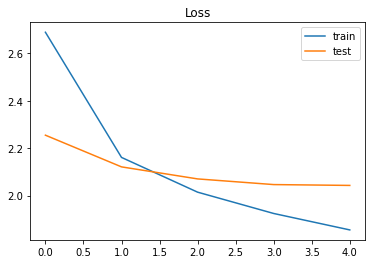

In [96]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [119]:
new_complaint = ['AmItheAsshole']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
print(pred)

[[0.4278486  0.02833984 0.02807295 0.01466235 0.00709631 0.00079225
  0.00237877 0.01731049 0.02804034 0.00222745 0.00534218 0.00495729
  0.01263911 0.01041621 0.01332779 0.02741133 0.00814627 0.0249903
  0.00324156 0.00393021 0.00994608 0.00372014 0.0032677  0.04702461
  0.00412855 0.01489068 0.00713158 0.00664426 0.01210253 0.00617419
  0.03485863 0.00558281 0.05930565 0.0036284  0.01669675 0.07303024
  0.00281506 0.00984275 0.00803774]]


### Heatmap for RNN model

In [187]:
a = pd.get_dummies(df['subreddit'])
label = list(a.columns)

In [136]:
from sklearn.metrics import confusion_matrix

In [141]:
y_pred = model.predict(X_test)

In [143]:
matrix = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))

<AxesSubplot:>

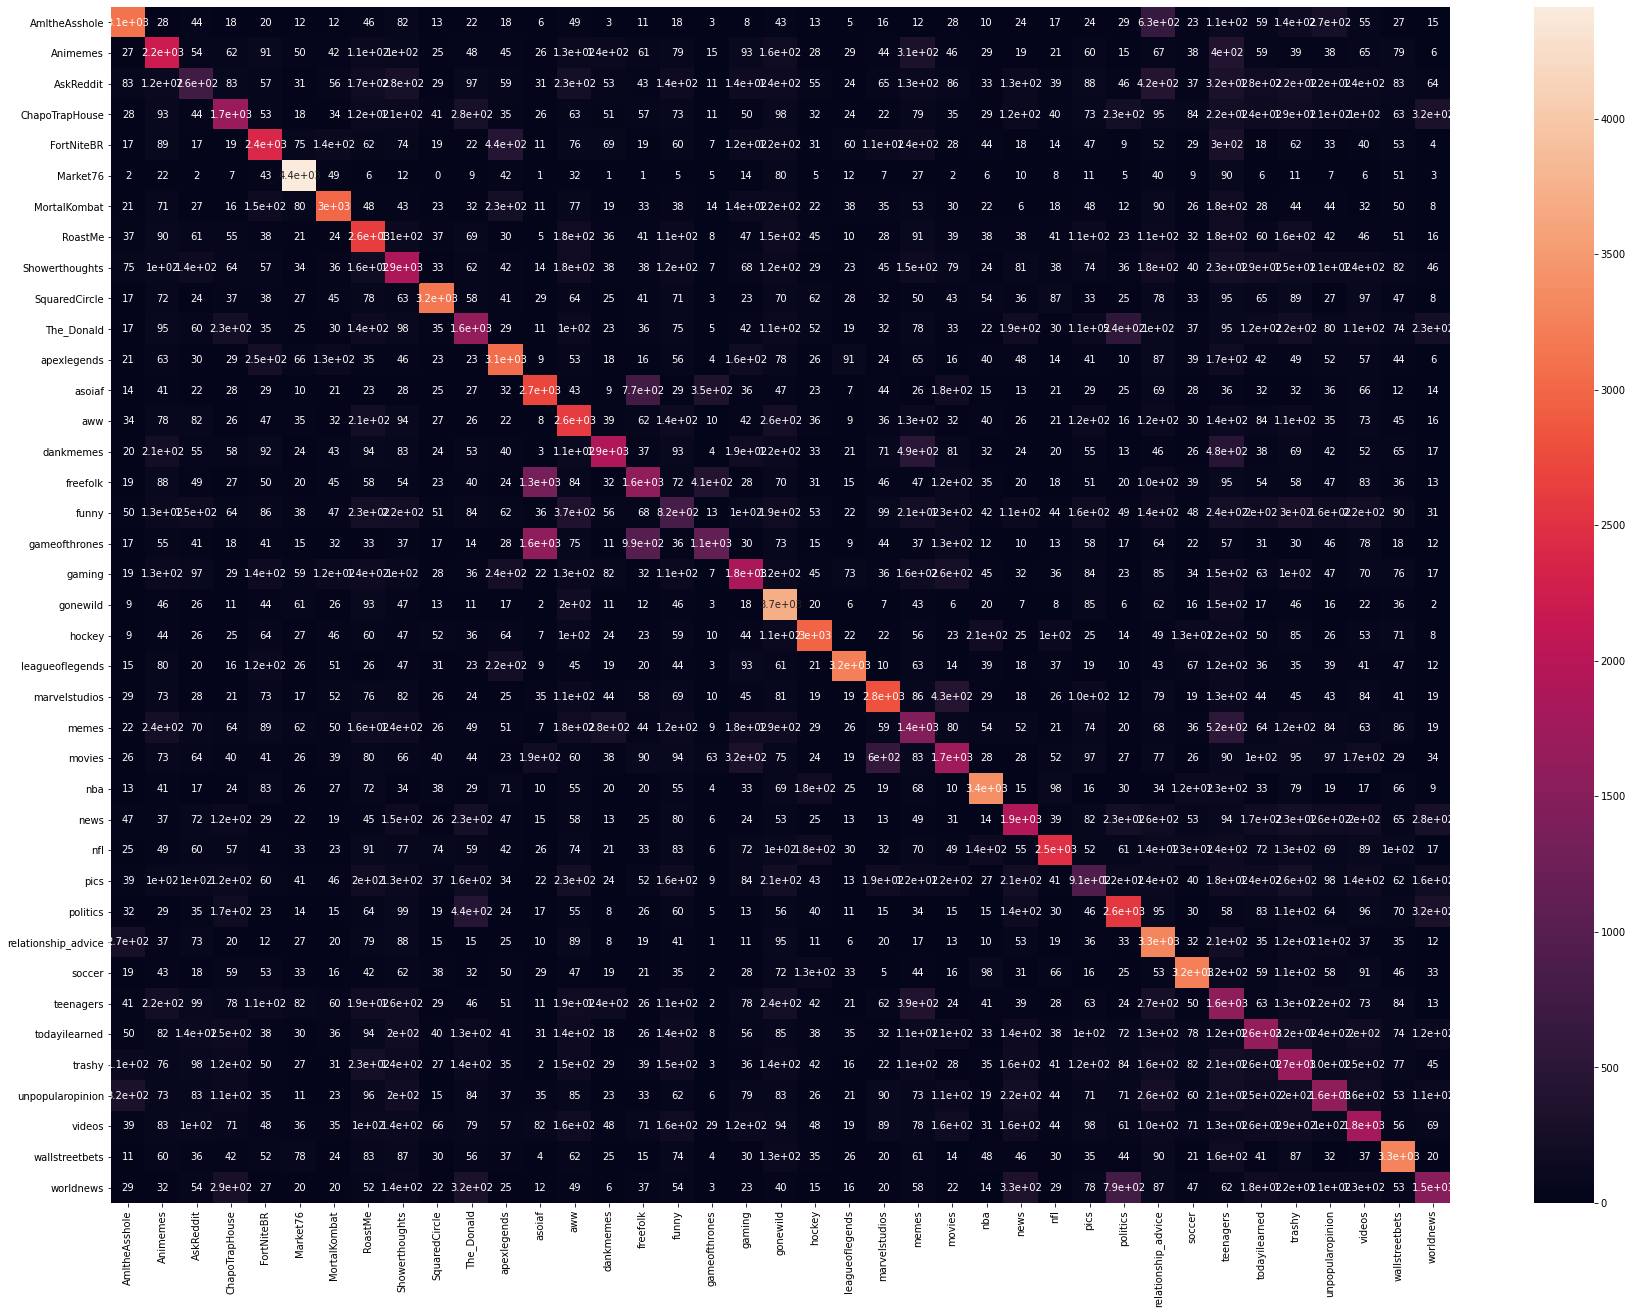

In [151]:
import seaborn as sn
df_cm = pd.DataFrame(matrix, index = [i for i in label],
                  columns = [i for i in label])
plt.figure(figsize = (30,22))
sn.heatmap(df_cm, annot=True)

In [152]:
a = pd.get_dummies(df['subreddit'])
label = list(a.columns)

In [153]:
label

['AmItheAsshole',
 'Animemes',
 'AskReddit',
 'ChapoTrapHouse',
 'FortNiteBR',
 'Market76',
 'MortalKombat',
 'RoastMe',
 'Showerthoughts',
 'SquaredCircle',
 'The_Donald',
 'apexlegends',
 'asoiaf',
 'aww',
 'dankmemes',
 'freefolk',
 'funny',
 'gameofthrones',
 'gaming',
 'gonewild',
 'hockey',
 'leagueoflegends',
 'marvelstudios',
 'memes',
 'movies',
 'nba',
 'news',
 'nfl',
 'pics',
 'politics',
 'relationship_advice',
 'soccer',
 'teenagers',
 'todayilearned',
 'trashy',
 'unpopularopinion',
 'videos',
 'wallstreetbets',
 'worldnews']

## CNN first attemp
### The final RNN code is in the CNN ipynb file

In [165]:
# Importing libraries
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# Padding the data samples to a maximum review length in words
max_words = 250
# X_train = sequence.pad_sequences(X_train, maxlen=max_words)
# X_test = sequence.pad_sequences(X_test, maxlen=max_words)
# Building the CNN Model
model = Sequential()      # initilaizing the Sequential nature for CNN model
# Adding the embedding layer which will take in maximum of 450 words as input and provide a 32 dimensional output of those words which belong in the top_words dictionary
model.add(Embedding(50000, 32, input_length=max_words)) 
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(39, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 250, 32)           1600000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 250, 32)           3104      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 125, 32)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 250)               1000250   
_________________________________________________________________
dense_17 (Dense)             (None, 39)                9789      
Total params: 2,613,143
Trainable params: 2,613,143
Non-trainable params: 0
___________________________________________

In [181]:
#split data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 50)

#fit data
model.fit(X_train, Y_train, 
          epochs = 20, 
          batch_size=256, verbose=2)

#score
scores = model.evaluate(X_test, Y_test, verbose=0)

#get accuaracy on test set
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/20
3047/3047 - 125s - loss: 0.0393 - accuracy: 0.7167
Epoch 2/20
3047/3047 - 122s - loss: 0.0391 - accuracy: 0.7182
Epoch 3/20
3047/3047 - 120s - loss: 0.0389 - accuracy: 0.7192
Epoch 4/20
3047/3047 - 121s - loss: 0.0388 - accuracy: 0.7204
Epoch 5/20
3047/3047 - 122s - loss: 0.0387 - accuracy: 0.7215
Epoch 6/20
3047/3047 - 123s - loss: 0.0385 - accuracy: 0.7225
Epoch 7/20
3047/3047 - 124s - loss: 0.0384 - accuracy: 0.7232
Epoch 8/20
3047/3047 - 122s - loss: 0.0383 - accuracy: 0.7241
Epoch 9/20
3047/3047 - 122s - loss: 0.0382 - accuracy: 0.7251
Epoch 10/20
3047/3047 - 122s - loss: 0.0381 - accuracy: 0.7259
Epoch 11/20
3047/3047 - 124s - loss: 0.0380 - accuracy: 0.7268
Epoch 12/20
3047/3047 - 123s - loss: 0.0378 - accuracy: 0.7281
Epoch 13/20
3047/3047 - 123s - loss: 0.0377 - accuracy: 0.7284
Epoch 14/20
3047/3047 - 123s - loss: 0.0376 - accuracy: 0.7296
Epoch 15/20
3047/3047 - 121s - loss: 0.0375 - accuracy: 0.7303
Epoch 16/20
3047/3047 - 118s - loss: 0.0374 - accuracy: 0.7307
E

### Heatmap for CNN model

In [182]:
a = pd.get_dummies(df['subreddit'])
label = list(a.columns)

In [183]:
from sklearn.metrics import confusion_matrix

In [184]:
y_pred = model.predict(X_test)

In [185]:
matrix = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))

<AxesSubplot:>

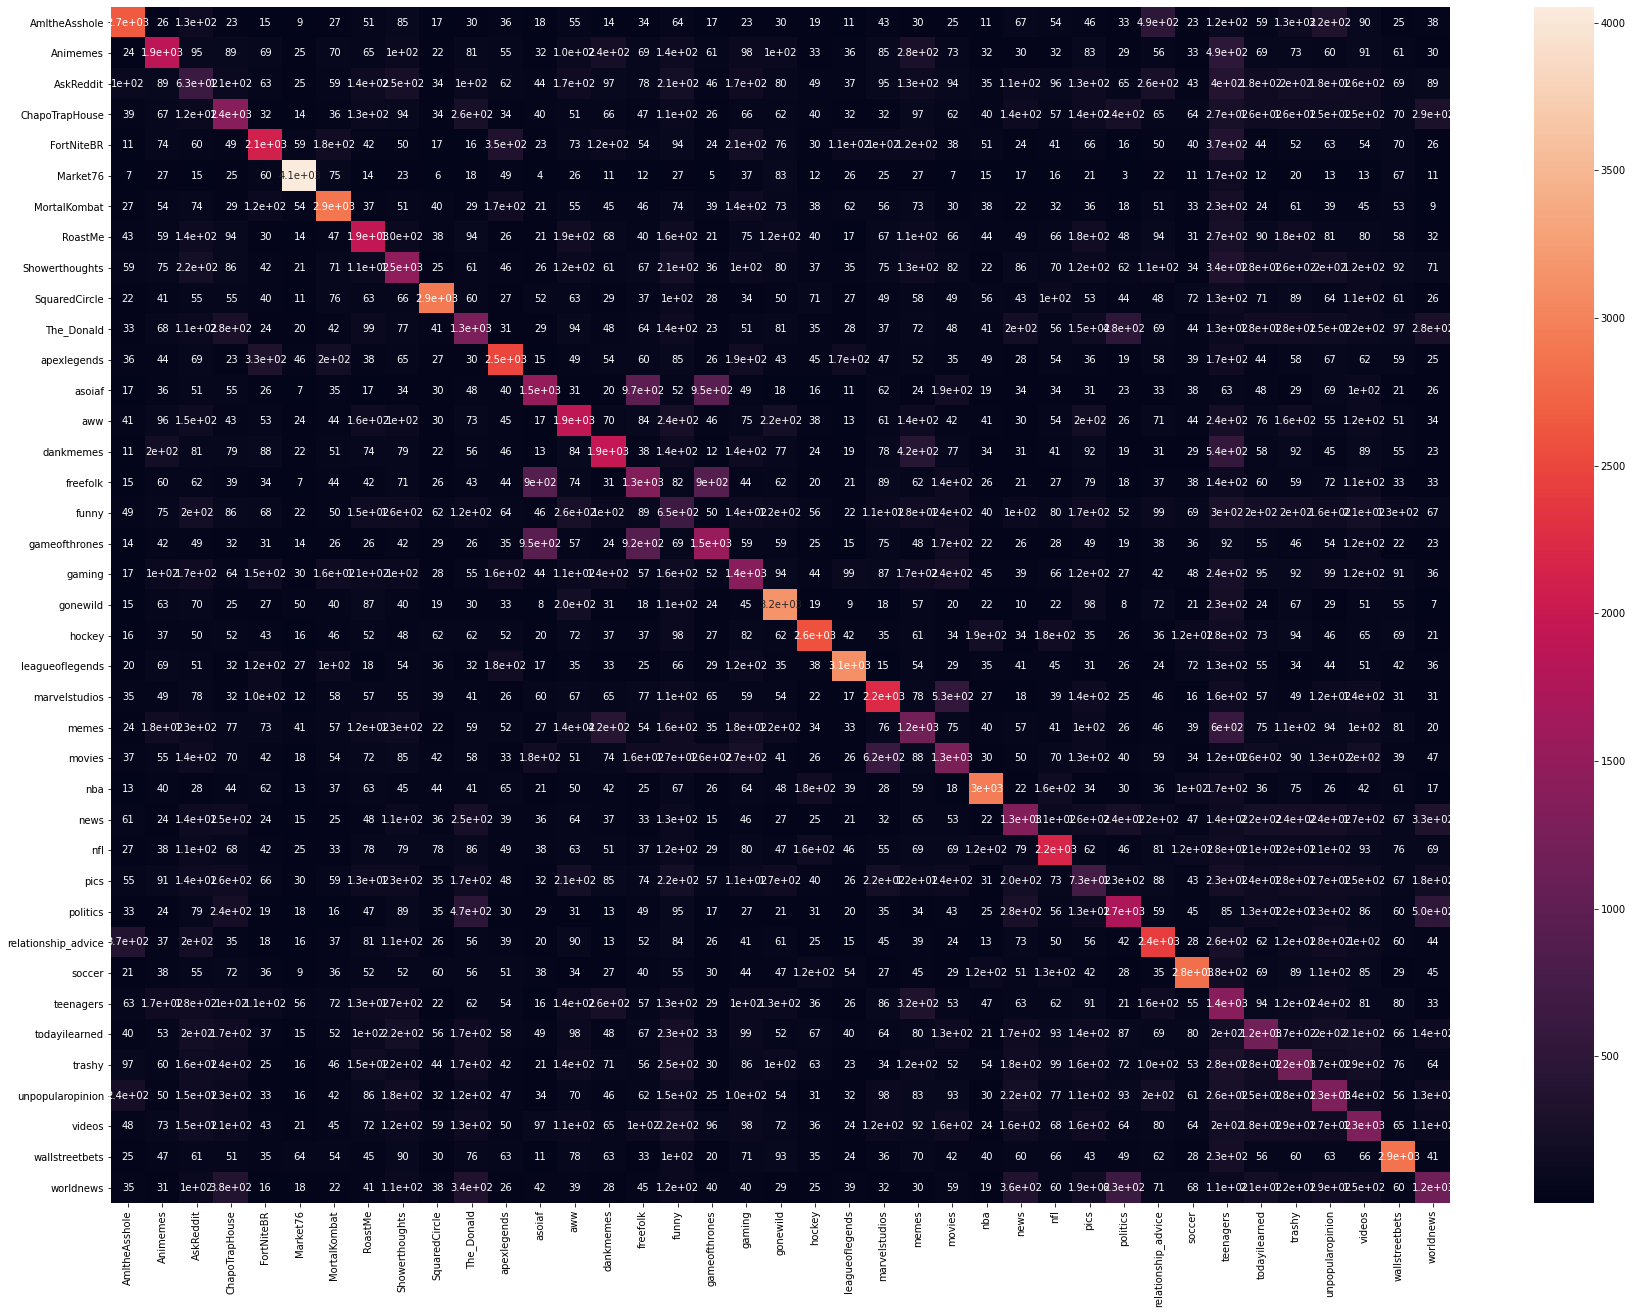

In [186]:
import seaborn as sn
df_cm = pd.DataFrame(matrix, index = [i for i in label],
                  columns = [i for i in label])
plt.figure(figsize = (30,22))
sn.heatmap(df_cm, annot=True)